In [1]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import nltk
from nltk.corpus import stopwords
from transformers import BertModel, BertTokenizer
import seaborn as sns
from sentence_transformers.cross_encoder import CrossEncoder

# Contextual embeddings

In [2]:

tokenizer = AutoTokenizer.from_pretrained("sentence-transformers/all-mpnet-base-v2")
model = AutoModel.from_pretrained("sentence-transformers/all-mpnet-base-v2")

In [3]:
sentence_a = "I want a recipe with tomato"
sentence_b = "Give me a recipe for a pizza with tomato and cheese"
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True)

input_ids = inputs['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
print(tokens)

['<s>', 'i', 'want', 'a', 'recipe', 'with', 'tomato', '</s>', '</s>', 'give', 'me', 'a', 'recipe', 'for', 'a', 'pizza', 'with', 'tomato', 'and', 'cheese', '</s>']


In [4]:
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True, output_attentions=True)
attention = outputs.attentions
hidden_states = outputs.hidden_states

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


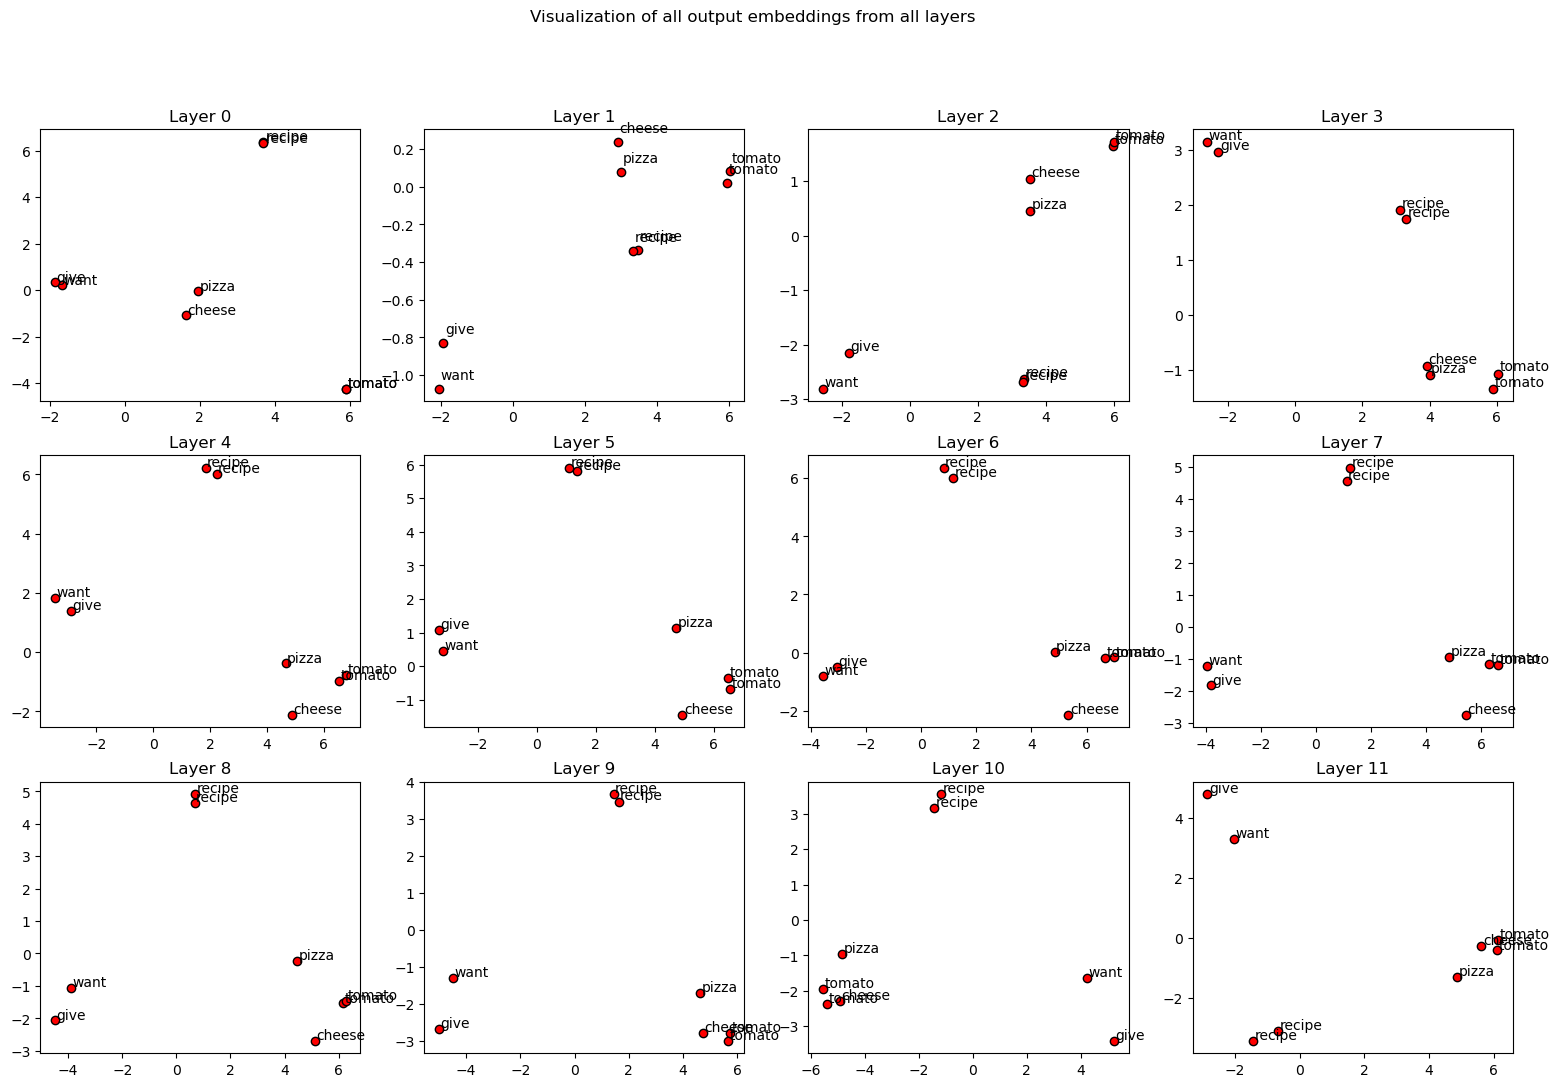

In [5]:


nltk.download('stopwords')
english_stopwords = set(stopwords.words('english'))
english_stopwords.add('<s>')
english_stopwords.add('</s>')

layer = 1

rows = 3
cols = 4
fig, ax_full = plt.subplots(rows, cols)
fig.set_figheight(rows*4)
fig.set_figwidth(cols*4+3)
plt.rcParams.update({'font.size': 6})


layer = 0
my_stop_words = {'is', 'the'}
for r in range(rows):
    for c in range(cols):
       
        ax = ax_full[r,c]
        
        plt.rcParams.update({'font.size': 10})
        current_hidden_state = hidden_states[layer][0].detach().numpy()
        
        if current_hidden_state.shape[1] == 2:
            twodim = current_hidden_state
        else:
            twodim = PCA().fit_transform(current_hidden_state)[:,:2]    

        plt.style.use('default')
      
        for word, (x,y) in zip(tokens, twodim):
            if word.lower() not in english_stopwords:
                im = ax.scatter(x, y, edgecolors='k', c='r')
                ax.text(x+0.05, y+0.05, word)
            
        
        # Show all ticks and label them with the respective list entries
        ax.set_title("Layer " + str(layer))
            
        # Loop over data dimensions and create text annotations.
        layer = layer + 1

fig.suptitle("Visualization of all output embeddings from all layers")
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ASUS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


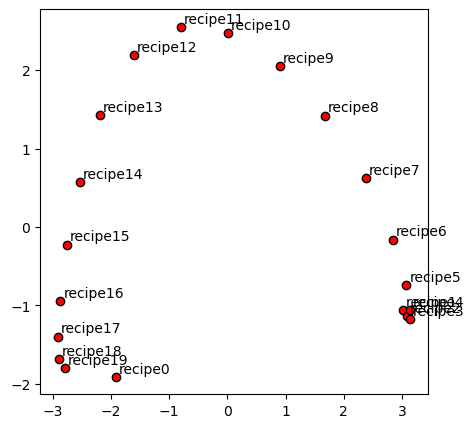

In [6]:

model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name, output_hidden_states=True, output_attentions=True)

sentence_a = "recipe "*20
inputs = tokenizer.encode_plus(sentence_a, return_tensors='pt', add_special_tokens=False, max_length = 512, truncation = True)

input_ids = inputs['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)

with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True, output_attentions=True)
attention = outputs.attentions
hidden_states = outputs.hidden_states

nltk.download('stopwords')
english_stopwords = set(stopwords.words('english'))
english_stopwords.add('<s>')
english_stopwords.add('</s>')

layer = 11

fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(5)
plt.rcParams.update({'font.size': 10})

current_hidden_state = hidden_states[layer][0].detach().numpy()

if current_hidden_state.shape[1] == 2:
    twodim = current_hidden_state
else:
    twodim = PCA().fit_transform(hidden_states[layer][0].detach().numpy())[:,:2]    
    
plt.style.use('default')
count = 0
for word, (x,y) in zip(tokens, twodim):
    if word.lower() not in english_stopwords:
        im = ax.scatter(x, y, edgecolors='k', c='r')
        ax.text(x+0.05, y+0.05, word +str(count))
        count += 1
    

# Show all ticks and label them with the respective list entries
# ax.set_title("Layer " + str(layer))
# fig.suptitle("Visualization of all output embeddings from all layers")
plt.show()

# Positional Embeddings

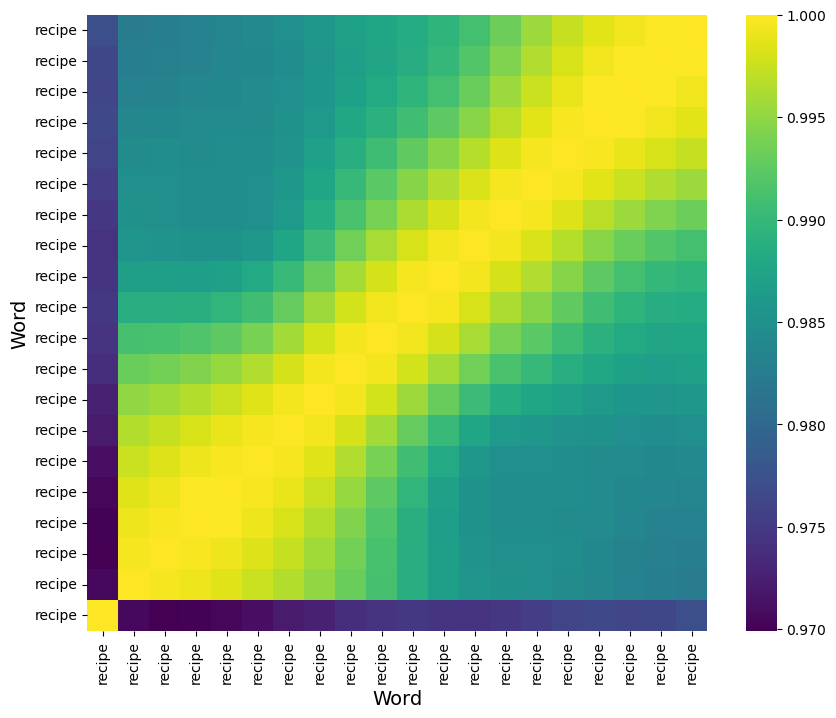

In [12]:


# Load pre-trained BERT model and tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name, output_hidden_states=True, output_attentions=True)

token = "recipe "*20

token_ids = tokenizer.encode(token, add_special_tokens=False, return_tensors="pt")[0]
input_ids = token_ids.unsqueeze(0)  # Add batch dimension

# Get positional embeddings from the BERT model
with torch.no_grad():
    outputs = model(input_ids)
    embeddings = outputs.hidden_states[12][0].numpy()  # shape: (seq_len, hidden_dim)

# Compute cosine similarity between word embeddings
similarity_matrix = cosine_similarity(embeddings)

# Prepare words for y-axis
words = [tokenizer.decode([id]) for id in token_ids]

# Plot similarity matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(similarity_matrix, cmap="viridis", yticklabels=words, xticklabels=words)
ax.invert_yaxis()
plt.xlabel("Word", fontsize=14)
plt.ylabel("Word", fontsize=14)
plt.show()


# Self-Attention

## Cross Encoder

O contexto de cada frase separada é calculada em cada embedding. Depois apenas comparamos os embeddings. Neste caso o similarity score é maior no dual encoding porque ele não tem em conta o contexto "misturado" quando fez o embedding de ambas as frases. Quando fazemos o cross encoder aí os embeddings são calculados de acordo com o contexto das duas frases entre elas. Assim os core dá ligeiramente pior e faz sentido porque apesar de falarem em massa o contexto é diferente e o cross encoder consegue captar esse contexto de melhor forma relativamente ao dual encoder.


Some weights of RobertaModel were not initialized from the model checkpoint at deepset/roberta-base-squad2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


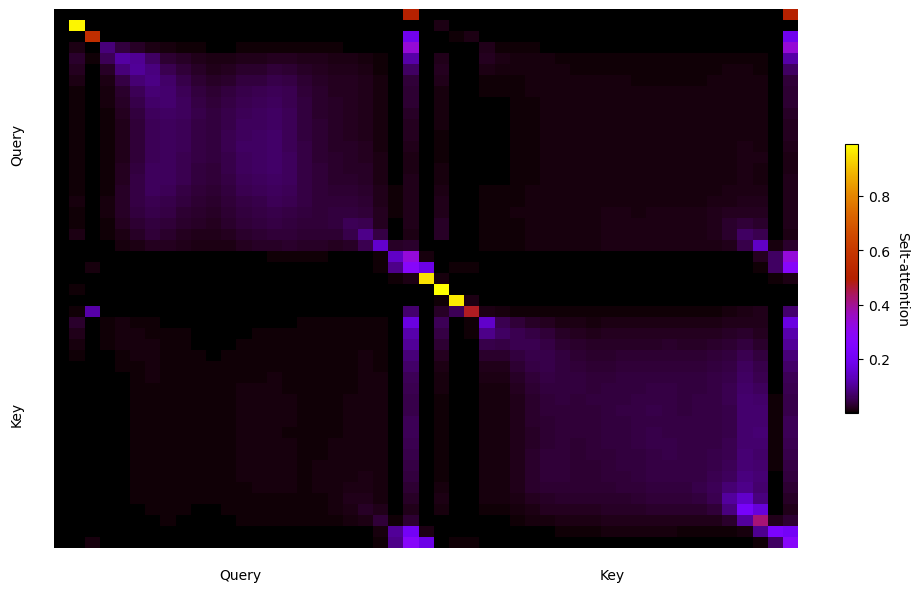

In [8]:
model_path = 'deepset/roberta-base-squad2'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModel.from_pretrained(model_path)

sentence_a = "recipe "*20
sentence_b = "ingredient "*20
inputs = tokenizer.encode_plus(sentence_a, sentence_b, return_tensors='pt', add_special_tokens=True, max_length = 512, truncation = True)

input_ids = inputs['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
tokens = tokenizer.convert_ids_to_tokens(input_id_list)

with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True, output_attentions=True)

attention = outputs.attentions
hidden_states = outputs.hidden_states

layer = 11

fig, ax = plt.subplots(1, 1)
fig.set_figheight(7)
fig.set_figwidth(12)
plt.rcParams.update({'font.size': 10})

j = 9

sattention = attention[layer][0][j].numpy()
sattention = np.flip(sattention, 0)

im = ax.pcolormesh(sattention, cmap='gnuplot')

ax.set_yticks(np.arange(len(tokens)))
ax.set_yticklabels(reversed(tokens))
ax.set_ylabel("Query")
ax.set_xticks(np.arange(len(tokens)))
ax.set_xticklabels(tokens)
ax.set_xlabel("Key")
ax.axis('off')
ax.text(0.25, -0.05, 'Query', ha='center', va='center', transform=ax.transAxes)
ax.text(0.75, -0.05, 'Key', ha='center', va='center', transform=ax.transAxes)
ax.text(-0.05, 0.25, 'Key', ha='center', va='center', transform=ax.transAxes, rotation='vertical')
ax.text(-0.05, 0.75, 'Query', ha='center', va='center', transform=ax.transAxes, rotation='vertical')
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    
cbar = fig.colorbar(im, ax=ax, location='right', shrink=0.5)
cbar.ax.set_ylabel("Selt-attention", rotation=-90, va="bottom")
plt.show()


In [9]:
"""
This example computes the score between a query and all possible
sentences in a corpus using a Cross-Encoder for semantic textual similarity (STS).
It output then the most similar sentences for the given query.
"""


# Pre-trained cross encoder
model = CrossEncoder("cross-encoder/stsb-distilroberta-base")

# We want to compute the similarity between the query sentence
query = "How much 1KG of pasta costs?"

# With all sentences in the corpus
corpus = [
    "How to make pasta?",
    "How to make pizza?",
    "What is the price of pasta per KG?",
]

# 1. We rank all sentences in the corpus for the query
ranks = model.rank(query, corpus)

# Print the scores
print("Query:", query)
for rank in ranks:
    print(f"{rank['score']:.2f}\t{corpus[rank['corpus_id']]}")

# 2. Alternatively, you can also manually compute the score between two sentences
sentence_combinations = [[query, sentence] for sentence in corpus]
scores = model.predict(sentence_combinations)

# Sort the scores in decreasing order to get the corpus indices
ranked_indices = np.argsort(scores)[::-1]
print("scores:", scores)
print("indices:", ranked_indices)

Query: How much 1KG of pasta costs?
0.82	What is the price of pasta per KG?
0.36	How to make pasta?
0.03	How to make pizza?
scores: [0.35502282 0.02596632 0.8238161 ]
indices: [2 0 1]


# Dual Encoder

Some weights of RobertaModel were not initialized from the model checkpoint at deepset/roberta-base-squad2 and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


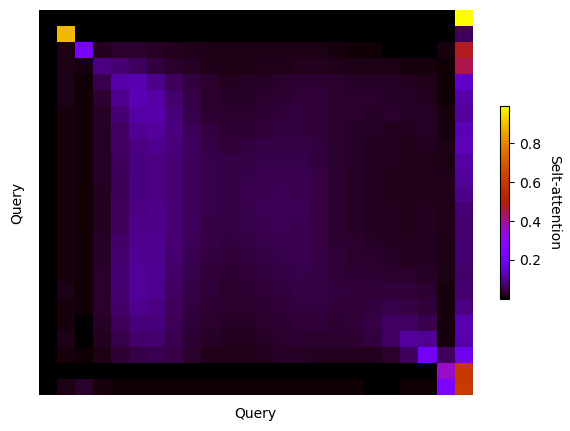

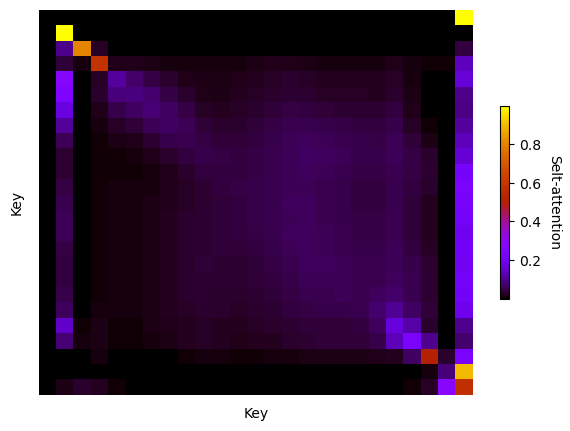

In [10]:

model_path = 'deepset/roberta-base-squad2'
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModel.from_pretrained(model_path)

sentence_a = "recipe " * 20
sentence_b = "ingredient " * 20

input_a = tokenizer.encode_plus(sentence_a, return_tensors='pt', add_special_tokens=True, max_length=512, truncation=True)
input_b = tokenizer.encode_plus(sentence_b, return_tensors='pt', add_special_tokens=True, max_length=512, truncation=True)

input_ids = input_a['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
tokens_a = tokenizer.convert_ids_to_tokens(input_id_list)

input_ids = input_b['input_ids']
input_id_list = input_ids[0].tolist() # Batch index 0
tokens_b = tokenizer.convert_ids_to_tokens(input_id_list)
with torch.no_grad():
    output_a = model(**input_a, output_hidden_states=True, output_attentions=True)
    output_b = model(**input_b, output_hidden_states=True, output_attentions=True)

attention_a = output_a.attentions
hidden_states_a = output_a.hidden_states
attention_b = output_b.attentions
hidden_states_b = output_b.hidden_states

layer = 11
j = 9
fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(7)
plt.rcParams.update({'font.size': 10})
ax.set_xlabel("Key")
ax.set_ylabel("Query")
cbar = fig.colorbar(im, ax=ax, location='right', shrink=0.5)
cbar.ax.set_ylabel("Selt-attention", rotation=-90, va="bottom")
ax.axis('off')
ax.text(0.5, -0.05, 'Query', ha='center', va='center', transform=ax.transAxes)
ax.text(-0.05, 0.5, 'Query', ha='center', va='center', transform=ax.transAxes, rotation='vertical')
sattention = attention_a[layer][0][j].numpy()
sattention = np.flip(sattention, 0)
plt.rcParams.update({'font.size': 10})
im = ax.pcolormesh(sattention, cmap='gnuplot')



fig, ax = plt.subplots(1, 1)
fig.set_figheight(5)
fig.set_figwidth(7)
plt.rcParams.update({'font.size': 10})
ax.set_xlabel("Key")
ax.set_ylabel("Query")
ax.axis('off')
ax.text(0.5, -0.05, 'Key', ha='center', va='center', transform=ax.transAxes)
ax.text(-0.05, 0.5, 'Key', ha='center', va='center', transform=ax.transAxes, rotation='vertical')
cbar = fig.colorbar(im, ax=ax, location='right', shrink=0.5)
cbar.ax.set_ylabel("Selt-attention", rotation=-90, va="bottom")
# ax.set_xticks(np.arange(len(tokens_b)))
# ax.set_xticklabels(tokens_b)
# ax.set_yticks(np.arange(len(tokens_b)))
# ax.set_yticklabels(reversed(tokens_b))
sattention = attention_b[layer][0][j].numpy()
sattention = np.flip(sattention, 0)

plt.rcParams.update({'font.size': 10})

im = ax.pcolormesh(sattention, cmap='gnuplot')



In [11]:

# Load the tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("cross-encoder/stsb-distilroberta-base")
model = AutoModel.from_pretrained("cross-encoder/stsb-distilroberta-base", output_hidden_states=True)

# Define your texts
text1 = 'How to make pasta?'
text2 = 'How much 1KG of pasta costs?'

# Tokenize the texts
inputs1 = tokenizer(text1, return_tensors="pt", max_length=128, truncation=True, padding=True)
inputs2 = tokenizer(text2, return_tensors="pt", max_length=128, truncation=True, padding=True)
# Forward pass through the model
with torch.no_grad():
    outputs1 = model(**inputs1)
    outputs2 = model(**inputs2)

# Get the last layer hidden states
hidden_states1 = outputs1.hidden_states[-1]
hidden_states2 = outputs2.hidden_states[-1]

# Calculate the mean of the hidden states
mean_hidden_states1 = torch.mean(hidden_states1, dim=1)
mean_hidden_states2 = torch.mean(hidden_states2, dim=1)

# Calculate similarity
similarity = cosine_similarity(mean_hidden_states1, mean_hidden_states2)

print(f"Similarity between text1 and text2 is {similarity.item()}")



Some weights of RobertaModel were not initialized from the model checkpoint at cross-encoder/stsb-distilroberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Similarity between text1 and text2 is 0.723459005355835
